<a href="https://colab.research.google.com/github/Padmini-RK/Yelp-Business-Data-Analysis/blob/SparkNLP-playground/SparkNLDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Mount the google drive on runtime to access review data stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Install PySpark, Spark NLP and nltk libraries 
! pip install --ignore-installed pyspark
! pip install --ignore-installed spark-nlp
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 409.4 kB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=6b69601509974ae7cbb0b2f6c25e8ff81a95640acd7dc1cceb3fad4ec5b1ebe3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.7/486.7 kB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#All imports needed for topic modelling and querying the spark dataframe
import sparknlp
from pyspark.sql import functions as F
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql import types as T
from pyspark.sql.functions import concat
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.clustering import LDA
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
#Start the spark session through sparknlp
spark = sparknlp.start()

In [12]:
#Read the review json data into spark dataframe
path_to_review_data = '/content/drive/My Drive/ADBMS/review.json'
review_data = spark.read.json(path_to_review_data).cache()

In [13]:
#Get user input - business id
user_business_input_id = input("Please input a business id. Here are a few to choose from - GBTPC53ZrG1ZBY3DT8Mbcw, _ab50qdWOk0DdB6XOrBitw ")

Please input a business id. Here are a few to choose from - GBTPC53ZrG1ZBY3DT8Mbcw, _ab50qdWOk0DdB6XOrBitw _ab50qdWOk0DdB6XOrBitw


In [14]:
#Column names from review_data df
text_col_name = 'text'
business_id_col_name = 'business_id'
stars_col_name = 'stars'
#Filter the review_data df to contain reviews of selected business
business_spec_reviews = review_data.select(text_col_name, business_id_col_name, stars_col_name).filter(F.col(business_id_col_name) == user_business_input_id).cache()
#Group the review by stars
reviews_by_stars = business_spec_reviews.groupBy('stars').count().sort('stars', ascending=True).cache()





In [17]:
#Get list of unique stars associated with reviews
list_of_unique_stars = reviews_by_stars.select(stars_col_name).rdd.flatMap(lambda x: x).collect()

In [18]:
#User can select the rating for analysis
from ipywidgets import interact 
def myfunction(chooseRating): 
    global selectedStar
    selectedStar = chooseRating
    return chooseRating 
w = interact(myfunction, chooseRating = list_of_unique_stars)

interactive(children=(Dropdown(description='chooseRating', options=(1.0, 2.0, 3.0, 4.0, 5.0), value=1.0), Outp…

In [19]:
#Filter the business_spec_reviews dataframe to contain reviews whose stars/ratings match with user input
review_text_col_name = 'text_for_analysis'
star_spec_reviews = business_spec_reviews.select(text_col_name, business_id_col_name, stars_col_name).filter((F.col(stars_col_name) >= selectedStar) & (F.col('stars') < selectedStar+1)).withColumnRenamed(text_col_name,review_text_col_name)

In [20]:
#Basic NLP pipeline that cleans the data and gets lemmatized unigrams from 'text_for_analysis' column

#DocumentAssembler is a transformer that transforms the raw data into Document type required by annotators
documentAssembler = DocumentAssembler() \
     .setInputCol(review_text_col_name) \
     .setOutputCol('document')
#Tokenizes raw text in document type columns into TokenizedSentence
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')
#Normalizer removes unnecessary charaters
normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)
#LemmatizerModel - returns a base dictionary
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')
#StopWordsCleaner will remove all stop words from lemmatized text
eng_stopwords = stopwords.words('english')
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('unigrams') \
     .setStopWords(eng_stopwords)
#Generates continuous sequences of tokens from lemmatized text
ngrammer = NGramGenerator() \
    .setInputCols(['lemmatized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')
#Perceptron model to tag words part-of-speech
pos_tagger = PerceptronModel.pretrained('pos_anc') \
    .setInputCols(['document', 'lemmatized']) \
    .setOutputCol('pos')
#Outputs the result into an array  
finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'pos']) 

pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                  
                 stopwords_cleaner, 
                 pos_tagger,
                 ngrammer,  
                 finisher])
#Fit all our estimators and then, transform the data with trained models and transformers
processed_review = pipeline.fit(star_spec_reviews).transform(star_spec_reviews)

processed_review.limit(5).show()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|   text_for_analysis|         business_id|stars|   finished_unigrams|     finished_ngrams|        finished_pos|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|Loved the chargri...|_ab50qdWOk0DdB6XO...|  3.0|[love, chargrille...|[love, the, charg...|[NN, DT, JJ, NN, ...|
|Maybe I had highe...|_ab50qdWOk0DdB6XO...|  3.0|[maybe, high, hop...|[maybe, i, have, ...|[RB, NNP, VBP, JJ...|
|The char-grilled ...|_ab50qdWOk0DdB6XO...|  3.0|[chargrilled, oys...|[the, chargrilled...|[DT, JJ, NN, VB, ...|
|If you don't have...|_ab50qdWOk0DdB6XO...|  3.0|[dont, wait, line...|[if, you, dont, h...|[IN, PRP, NN, VBP...|
|too salty and wai

In [21]:
#join all POS tags obtained previously
udf_join_arr = F.udf(lambda x: ' '.join(x), T.StringType())
processed_review  = processed_review.withColumn('finished_pos', udf_join_arr(F.col('finished_pos')))

In [22]:
#Extended Spark NLP pipeline to get POS tag n-grams that correspond to word n-grams

pos_documentAssembler = DocumentAssembler() \
     .setInputCol('finished_pos') \
     .setOutputCol('pos_document')

pos_tokenizer = Tokenizer() \
     .setInputCols(['pos_document']) \
     .setOutputCol('pos')

pos_ngrammer = NGramGenerator() \
    .setInputCols(['pos']) \
    .setOutputCol('pos_ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

pos_finisher = Finisher() \
     .setInputCols(['pos', 'pos_ngrams'])


pos_pipeline = Pipeline() \
     .setStages([pos_documentAssembler,                  
                 pos_tokenizer,
                 pos_ngrammer,  
                 pos_finisher])
     
processed_review = pos_pipeline.fit(processed_review).transform(processed_review)

#n-grams with their corresponding pos n-grams
processed_review.select('finished_ngrams', 'finished_pos_ngrams').limit(5).show()

+--------------------+--------------------+
|     finished_ngrams| finished_pos_ngrams|
+--------------------+--------------------+
|[love, the, charg...|[NN, DT, JJ, NN, ...|
|[maybe, i, have, ...|[RB, NNP, VBP, JJ...|
|[the, chargrilled...|[DT, JJ, NN, VB, ...|
|[if, you, dont, h...|[IN, PRP, NN, VBP...|
|[too, salty, and,...|[RB, NN, CC, VB, ...|
+--------------------+--------------------+



In [45]:
#Filter out not useful for topic modelling analysis POS tags from our unigrams
def filter_pos(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) if pos in ['NN', 'NNS', 'VB', 'VBP']]

udf_filter_pos = F.udf(filter_pos, T.ArrayType(T.StringType()))

processed_review = processed_review.withColumn('filtered_unigrams',
                                               udf_filter_pos(F.col('finished_unigrams'), 
                                                              F.col('finished_pos')))

processed_review.select('filtered_unigrams').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                         filtered_unigrams|
+------------------------------------------------------------------------------------------+
|                [food, wasnt, dont, split, want, split, cc, card, go, house, kensie, jake]|
|[table, take, group, hard, count, around, glass, sauce, shrimp, salty, bill, addons, oy...|
|[po, serve, chargrilled, oyster, swim, grease, mn, water, split, check, top, card, ment...|
|                                     [manager, want, large, borderline, business, forever]|
|[go, line, probably, long, maybe, go, crowd, place, get, theyre, theyre, everyone, bar,...|
+------------------------------------------------------------------------------------------+



In [46]:
#Filter out not useful for topic modelling analysis POS tags from our n-grams
def filter_pos_combs(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if (len(pos.split('_')) == 2 and \
                pos.split('_')[0] in ['NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['NN', 'NNS']) \
            or (len(pos.split('_')) == 3 and \
                pos.split('_')[0] in ['NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['NN', 'NNS', 'VB', 'VBP'] and \
                  pos.split('_')[2] in ['NN', 'NNS'])]
    
udf_filter_pos_combs = F.udf(filter_pos_combs, T.ArrayType(T.StringType()))

processed_review = processed_review.withColumn('filtered_ngrams',
                                               udf_filter_pos_combs(F.col('finished_ngrams'),
                                                                    F.col('finished_pos_ngrams')))

processed_review.select('filtered_ngrams').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                           filtered_ngrams|
+------------------------------------------------------------------------------------------+
|[food_wasnt, dont_split, split_check, split_cc, cc_pmt, use_card, be_cash, bourbon_hous...|
|[bring_glass, count_problem, problem_cocktail, cocktail_sauce, be_salty, soggy_watch, r...|
|[po_boy, cent_bread, wait_mn, add_gratuity, raw_oyster, cocktail_sauce, dining_experien...|
|[party_borderline, borderline_rude, rude_lose, party_borderline_rude, borderline_rude_l...|
|[crowd_table, be_shove, accommodate_everyone, messy_waitress, be_piece, couldnt_taste, ...|
+------------------------------------------------------------------------------------------+



In [47]:
#Combine unigram and n-gram into a single dataframe
processed_review = processed_review.withColumn('final', 
                                               concat(F.col('filtered_unigrams'), 
                                                      F.col('filtered_ngrams')))

processed_review.select('final').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                                     final|
+------------------------------------------------------------------------------------------+
|[food, wasnt, dont, split, want, split, cc, card, go, house, kensie, jake, food_wasnt, ...|
|[table, take, group, hard, count, around, glass, sauce, shrimp, salty, bill, addons, oy...|
|[po, serve, chargrilled, oyster, swim, grease, mn, water, split, check, top, card, ment...|
|[manager, want, large, borderline, business, forever, party_borderline, borderline_rude...|
|[go, line, probably, long, maybe, go, crowd, place, get, theyre, theyre, everyone, bar,...|
+------------------------------------------------------------------------------------------+



In [48]:
#Fit tf dictionary and then transform the data to vectors of counts.
tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_review)
tf_result = tf_model.transform(processed_review)

In [49]:
idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)


In [50]:
#To model topics in our data we use LDA (Latent Dirichlet Allocation) algorithm.
#To this we provide the number of topics we presume our data contains and the number of iterations for the LDA algorithm.
#Then, we initialize the model and train it.

num_topics = 4
max_iter = 10
lda = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

vocab = tf_model.vocabulary

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]
       
udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

num_top_words = 10

topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=90)


+-----+----------------------------------------------------------------+
|topic|                                                      topicWords|
+-----+----------------------------------------------------------------+
|    0|  [time, try, please, id, waste, tip, figure, à, table, overall]|
|    1|  [acme, wait, split, party, get, come, say, back, oyster, food]|
|    2|[oyster, go, tell, like, taste, also, bar, server, gumbo, would]|
|    3|  [feel, way, close, show, staff, never, upset, kick, treat, im]|
+-----+----------------------------------------------------------------+



In [30]:
#Convert to pandas dataframe
final_topic_words_pndf = topics.toPandas()

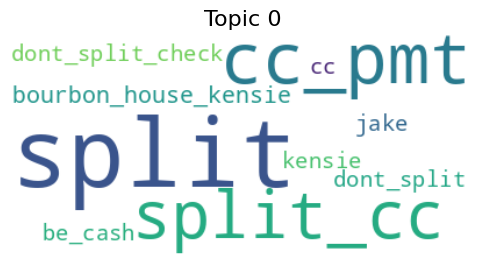

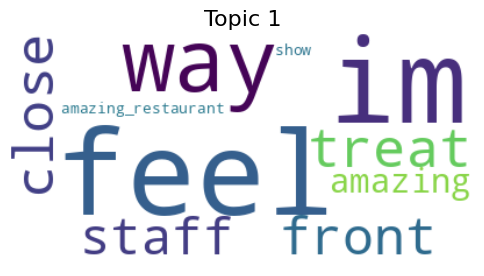

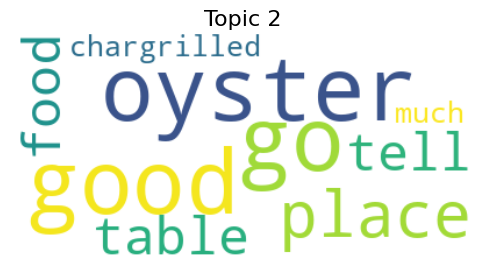

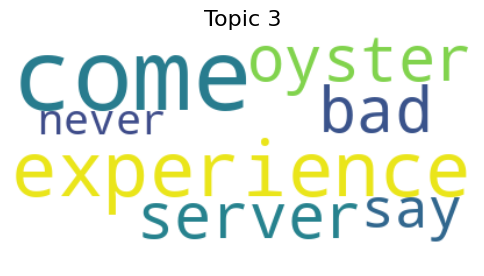

In [31]:
#Generate word cloud for each of the topics
for i in range(num_topics):
  text = " ".join(final_topic_words_pndf.topicWords[i])
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  plt.figure( figsize=(6,4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.axis("off")
  plt.show()

In [26]:
#Write all the outputs to a single file
with open('/content/drive/My Drive/ADBMS/multipleOutput.html', 'w') as _file:
       _file.write("These are the topics identified from reviews <br>" + final_topic_words_pndf.to_html() + "<br><br><br><br>" + "images")